In [1]:
import pandas as pd
from collections import OrderedDict
import os.path as osp
import os
import sys
import torch
from overflowDataset import OpenFlowDataset
from tqdm import tqdm
from neighbor_sampler import NeighborSampler
import argparse

import scipy
import numpy as np

__file__ = os.path.abspath('')
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'taobao', 'UserBehavior.csv')

print(path)

/home/zz/Home/gnn/../data/taobao/UserBehavior.csv


In [2]:
data=pd.read_csv(path,header=None,index_col=None)


# Data cleaning
data.columns=['User_Id','Item_Id','Category_Id','Behavior_type','Timestamp']
data = data.sort_values('Timestamp')
data = data[data["Timestamp"]>0]

In [3]:
# Message passing in bipartite graphs?

src = torch.tensor(data['User_Id'].values, dtype=torch.long)
dst = torch.tensor(data['Item_Id'].values, dtype=torch.long)
t = torch.tensor(data['Timestamp'].values)

In [4]:
from torch_geometric.data import Data

data = Data(edge_index=torch.stack([src, dst], dim=0), edge_attr=t)

In [5]:
from collections import OrderedDict
 
class LRUCache:
    def __init__(self, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity
        self.stats = []
 
    def get(self, key: int) -> int:
        if key not in self.cache:
            self.stats.append(0)
            return -1
        else:
            self.stats.append(1)
            self.cache.move_to_end(key)
            return self.cache[key]
 
    def put(self, key: int, value: int) -> None:
        self.cache[key] = value
        self.cache.move_to_end(key)
        if len(self.cache) > self.capacity:
            self.cache.popitem(last = False)

In [18]:
import os.path as osp
import os
import torch
from overflowDataset import OpenFlowDataset
from tqdm import tqdm
from neighbor_sampler import NeighborSampler

num_edges = len(data.edge_index[0])
subset = int(num_edges / 200)
# Assume CPU cache is 10% of data
CPUCacheNum = int(subset / 5)

# Assume GPU cache is 0.25% of data
GPUCacheNum = int(subset / 200)
node_ids = torch.flatten(data.edge_index.t())

CPUCacheLRU  = LRUCache(CPUCacheNum)
GPUCache = LRUCache(GPUCacheNum)

temp_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=node_ids[len(node_ids)-2*subset:], batch_size=2)

pbar = tqdm(total=subset*2)
for batch_size, ids, adjs in temp_loader:
  for i in ids:
    i = int(i)
    val = CPUCacheLRU.get(i)
    if (val == -1):
      # Fetch from SSD
      CPUCacheLRU.put(i,i)
  pbar.update(batch_size)
pbar.close()

100%|██████████| 1001504/1001504 [02:42<00:00, 6161.35it/s]


In [19]:
len(data.edge_index[0])

100150489

In [23]:
def sum_intervals(vals):
    interval_size = 20000
    num_intervals = len(vals) // interval_size
    interval_sums = []
    for i in range(num_intervals):
        start_index = i * interval_size
        end_index = start_index + interval_size
        interval = vals[start_index:end_index]
        interval_sum = sum(interval) / interval_size
        interval_sums.append(interval_sum)
    return interval_sums

def getHitRate(stats):
    return sum(stats)/len(stats)

In [24]:
stats = list(CPUCacheLRU.stats)
intervals_dynamic = sum_intervals(stats)
getHitRate(intervals_dynamic)

0.19482525412960625

Text(0.5, 0, 'Iterations')

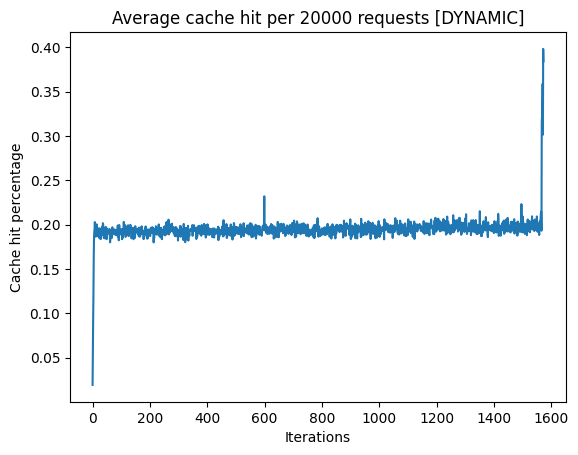

In [25]:
import matplotlib.pyplot as plt

plt.plot(intervals_dynamic)
plt.title('Average cache hit per 20000 requests [DYNAMIC]')
plt.ylabel('Cache hit percentage')
plt.xlabel('Iterations')

In [26]:
# STATIC CACHE

import scipy
import numpy as np

coo = data.edge_index.numpy()
v = np.ones_like(coo[0])
coo = scipy.sparse.coo_matrix((v, (coo[0], coo[1])), shape=(num_edges, num_edges))
csc = coo.tocsc()
csr = coo.tocsr()

csc_indptr_tensor = torch.from_numpy(csc.indptr.astype(np.int64))
csr_indptr_tensor = torch.from_numpy(csr.indptr.astype(np.int64))
out_num_neighbors = csr_indptr_tensor[1:] - csr_indptr_tensor[:-1]
in_num_neighbors = (csc_indptr_tensor[1:] - csc_indptr_tensor[:-1])

sorted_vals_out, indices_out = torch.sort(out_num_neighbors, descending=True)
sorted_vals_in, indices_in = torch.sort(in_num_neighbors, descending=True)

In [27]:
subset = int(num_edges / 200)
node_ids = torch.flatten(data.edge_index.t())

# Assume CPU cache is 10% of data
CPUCacheNum = int(subset / 5)

# Assume GPU cache is 0.25% of data
GPUCacheNum = int(subset / 200)

CPUCacheStatic  = LRUCache(CPUCacheNum)
GPUCache = LRUCache(GPUCacheNum)

# Populate cache with highest out degree nodes
for i in range(CPUCacheNum):
    val = int(indices_out[i])
    CPUCacheStatic.put(val, val)

In [28]:
temp_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=node_ids[len(node_ids)-2*subset:], batch_size=2)

pbar = tqdm(total=subset*2)
for batch_size, ids, adjs in temp_loader:
  for i in ids:
    i = int(i)
    val = CPUCacheStatic.get(i)
  pbar.update(batch_size)
pbar.close()

100%|██████████| 1001504/1001504 [02:21<00:00, 7069.29it/s]


In [29]:
stats = list(CPUCacheStatic.stats)
intervals_static = sum_intervals(stats)
getHitRate(intervals_static)

0.2814082274459975

Text(0.5, 0, 'Iterations')

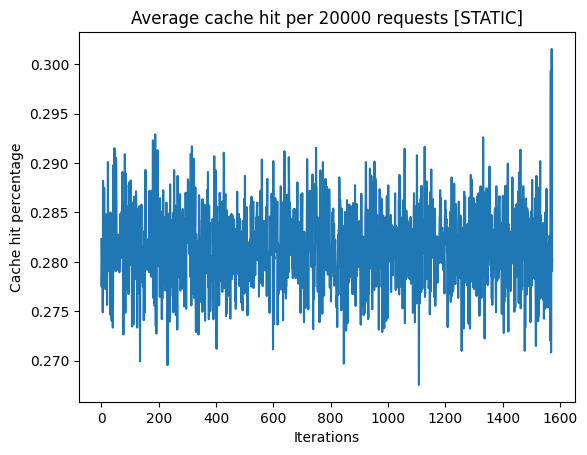

In [30]:
import matplotlib.pyplot as plt

plt.plot(intervals_static)
plt.title('Average cache hit per 20000 requests [STATIC]')
plt.ylabel('Cache hit percentage')
plt.xlabel('Iterations')